In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform, loguniform
import matplotlib.pyplot as plt
import warnings

In [ ]:
df_train = pd.read_csv('blood_samples.csv')
X = df_train.drop('Disease', axis=1)  # Caracteristicas
y = df_train['Disease']  # Etiquetas
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
def evaluate_svm(x_train, y_train, x_test, y_test, kernel='poly',do_cross_validation=True):

   model = svm.SVC(kernel=kernel)
   model.fit(x_train, y_train)

   predictions = model.predict(x_test)

   print("Reporte de clasificación:\n", classification_report(y_test, predictions))

   if do_cross_validation:
      cv = cross_val_score(model, X, y, cv=5, scoring='accuracy') #Numero de iteraciones = 5

      print("Resultados de validación cruzada:")
      for i, accuracy in enumerate(cv):
         print(f"Iteración {i+1}: Accuracy = {accuracy}")

      print(f"Accuracy promedio: {np.mean(cv)}")
      print(f"Desviación estándar del accuracy: {np.std(cv)}")

   cm = confusion_matrix(y_test, predictions, labels = model.classes_)
   disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model.classes_)
   disp.plot()
   plt.show()

In [ ]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='linear', do_cross_validation=False)

In [ ]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='poly', do_cross_validation=True)

In [ ]:
evaluate_svm(x_train, y_train, x_test, y_test, kernel='rbf', do_cross_validation=False)


El código optimiza, entrena y evalúa un modelo de Máquinas de Vectores de Soporte (SVM) con visualización comparativa de la precisión para diferentes parámetros. Se realizan los siguientes pasos:

**Ajuste de hiperparámetros (Randomized Search CV):**

Se define un espacio de búsqueda para los hiperparámetros del SVM (kernel, C, gamma, etc.).
El modelo SVM se entrena con diferentes combinaciones de hiperparámetros utilizando validación cruzada y se evalúa su precisión.
Se encuentra la mejor configuración de hiperparámetros según la mayor precisión media.

**Entrenamiento y evaluación:**

Se crea un modelo SVM final con los mejores hiperparámetros.
El modelo final se entrena en los datos de entrenamiento.
Se realizan predicciones en los datos de prueba.
Se evalúa el rendimiento del modelo mediante un informe de clasificación y una matriz de confusión.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_distributions = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': loguniform(0.001, 100.0),
        'gamma': loguniform(0.00001, 1.0),
        'degree': [2, 3, 4, 5],
        'coef0': uniform(-1.0, 1.0),
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': loguniform(1e-6, 1e-2),
        'cache_size': [100, 200, 500],
        'class_weight': ['balanced', None],
        'verbose': [0],
        'max_iter': [1000, 2000, 5000],
        'decision_function_shape': ['ovo', 'ovr'],
    }

    model = svm.SVC()

    random_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5, scoring='accuracy', n_jobs=8)

    random_search.fit(x_train, y_train)

    best_params = random_search.best_params_

    print("Mejores parámetros:", best_params)
    print("Mejor puntaje:", random_search.best_score_)

    best_model = svm.SVC(**best_params)
    best_model.fit(x_train, y_train)

    predictions = best_model.predict(x_test)
    print("Reporte de clasificación:\n", classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions, labels = best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)
    disp.plot()
    plt.show()

Ploteamos los distintos parametros en relaccion a su accuracy, pero como RandomizedSearchCV mezcla los parametros de manera aleatoria, los graficos no tendran una relaccion consistente.

In [ ]:
df_random = pd.DataFrame(random_search.cv_results_)

params_of_interest = ['param_kernel', 'param_C', 'param_gamma', 'param_degree']

for param in params_of_interest:
    plt.figure(figsize=(10, 6))
    # Filtrar el DataFrame para eliminar las filas donde el parámetro es None
    filtered_df = df_random[df_random[param].notna()]
    plt.plot(filtered_df[param], filtered_df['mean_test_score'], 'o')
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    plt.show()

Volvermos a hacer la busqueda pero con GridSearchCV para que la busqueda sea mas exhaustiva y consistente en los parametros que con RandomizedSearchCV 

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-3, 2, 6),
        'gamma': np.logspace(-5, 0, 6),
        'degree': [2, 3],
        'shrinking': [True],
        'probability': [True],
        'class_weight': [None],
        'verbose': [0],
        'max_iter': [1000],
        'decision_function_shape': ['ovr'],
    }

    model = svm.SVC()

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=8)

    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_

    print("Mejores parámetros:", best_params)
    print("Mejor puntaje:", grid_search.best_score_)

    best_model = svm.SVC(**best_params)
    best_model.fit(x_train, y_train)

    predictions = best_model.predict(x_test)
    print("Reporte de clasificación:\n", classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions, labels = best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)
    disp.plot()
    plt.show()


In [ ]:
df_grid = pd.DataFrame(grid_search.cv_results_)

params_of_interest = ['param_kernel', 'param_C', 'param_gamma', 'param_degree']

for param in params_of_interest:
    plt.figure(figsize=(10, 6))
    filtered_df = df_grid[df_grid[param].notna()]
    plt.plot(filtered_df[param], filtered_df['mean_test_score'], 'o')
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    plt.show()

Resultados con RandomizedSearchCV

    Mejores parámetros: {
        'C': 96.39636288596346,
        'cache_size': 200,
        'class_weight': 'balanced',
        'coef0': -0.6719290189526498,
        'decision_function_shape': 'ovo',
        'degree': 4,
        'gamma': 0.32329765890129275,
        'kernel': 'rbf',
        'max_iter': 2000,
        'probability': True,
        'shrinking': True,
        'tol': 0.00025189034577900667,
        'verbose': 0
        }

    Mejor puntaje: 0.9435909404751486
    
Resultados con GridSearchCV

    Mejores parámetros: {
        'C': 10.0,
        'class_weight': None,
        'decision_function_shape': 'ovr',
        'degree': 2,
        'gamma': 1.0,
        'kernel': 'rbf',
        'max_iter': 1000,
        'probability': True,
        'shrinking': True,
        'verbose': 0
        }
        
    Mejor puntaje: 0.9418268809989205

La función `stratified_cross_validation` realiza una validación cruzada estratificada en un conjunto de datos utilizando un modelo SVC, y como previamente hemos sacado los hiperparametros optimos usare esos

In [ ]:
def stratified_cross_validation(X, y, model, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)

    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        
    print(f"Precision por particion: {accuracies}")
    print(f"Precision media: {np.mean(accuracies)}")
    print(f"Desviacion estandar de la precision: {np.std(accuracies)}")


In [ ]:
model = SVC(C=10.0,class_weight=None,decision_function_shape='ovr',degree=2,gamma=1.0,kernel='rbf',max_iter=1000,probability=True,shrinking=True)
accuracies = stratified_cross_validation(X, y, model)

**Precisión por partición**: Rendimiento bueno en las 3 primeras particiones pero disminuye en los 2 últimos. Esto podría indicar que mi modelo está sobreajustando ciertas partes de los datos y no generaliza bien a otras partes.

**Precisión media**: El modelo fue correcto un 92% de las veces en las particiones.

**Desviación estándar de la precisión**: La desviación estándar es de 0.10, lo que indica que hubo una variabilidad del 10% en las precisiones de las particiones.


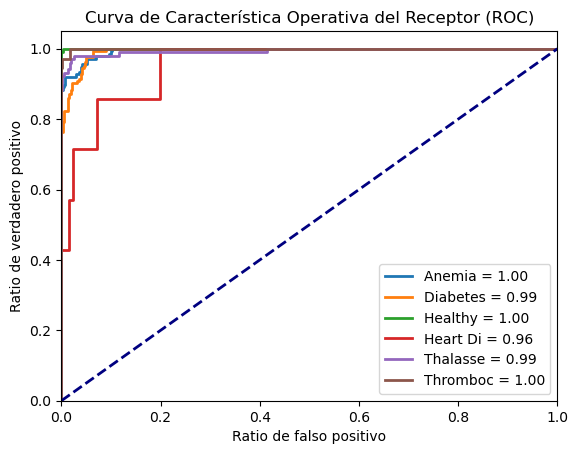

In [62]:
model = SVC(C=10.0,class_weight=None,decision_function_shape='ovr',degree=2,gamma=1.0,kernel='rbf',max_iter=1000,probability=True,shrinking=True)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
model.fit(x_train, y_train)
y_score = model.predict_proba(x_test)

fpr = []
tpr = []
roc_auc = []
lw=2

for i, class_name in enumerate(np.unique(y_test)):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

    plt.plot(fpr_i, tpr_i, lw=lw, label='{0} = {1:0.2f}'.format(class_name, roc_auc_i))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo')
plt.ylabel('Ratio de verdadero positivo')
plt.title('Curva de Característica Operativa del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

**Estos valores indican que el modelo tiene un excelente rendimiento en la clasificación de las clases**, ya que los valores AUC están muy cerca de 1, que es el valor óptimo. Un valor AUC de 1 significa que el modelo tiene una capacidad muy buena para distinguir entre la clase en cuestión y las demás clases. Un valor AUC de 0.5, representado por la línea diagonal punteada, indicaría que el modelo no tiene ninguna capacidad de clasificación más allá de la aleatoriedad. **Por lo tanto, los valores AUC cercanos a 1 son muy buenos**.
